## We now attempt to find out if the footnotes of the SEC filing has an effect on the transaction

In [87]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

# Remove warnings to keep outputs clean
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "snorkel_labels.csv"

COMPILED_DATA_FOLDER = "../../data_untracked/raw/sec_submissions/compiled"
FOOTNOTES_CSV = "FOOTNOTES.csv"

### Download this if haven't

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

## Load required datasets
1. `snorkel_labels.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [3]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "snorkel_prob", "snorkel_pred"]]
abnormal_transactions = abnormal_transactions.rename(columns={"snorkel_prob" : "probability",
                                                               "snorkel_pred" : "prediction"})
footnotes = pd.read_csv(f'{COMPILED_DATA_FOLDER}/{FOOTNOTES_CSV}')
print("Loading data")

Loading data


In [4]:
print(abnormal_transactions.shape)
print(footnotes.shape)

(778559, 5)
(6453264, 3)


In [5]:
footnotes.head()

,ACCESSION_NUMBER,FOOTNOTE_ID,FOOTNOTE_TXT
0,0001179110-14-011078,F1,Sale made pursuant to a Rule 10b5-1 Plan dated...
1,0001179110-14-011078,F2,Shares adjusted for those withheld to cover ta...
2,0001144204-14-040534,F3,"Includes 2,106 shares of common stock received..."
3,0001144204-14-040534,F2,Restricted shares of common stock issued pursu...
4,0001144204-14-040534,F1,Shares issued in lieu of cash for board services.


In [6]:
df_footnote = footnotes.copy()
df_footnote = df_footnote.sort_values(by=["ACCESSION_NUMBER", "FOOTNOTE_ID"])
df_footnote["FOOTNOTE_TXT"] = df_footnote["FOOTNOTE_TXT"].astype(str)
df_grouped = df_footnote.groupby("ACCESSION_NUMBER", sort=True)["FOOTNOTE_TXT"].apply(lambda x: " ".join(x)).reset_index()
df_grouped

,ACCESSION_NUMBER,FOOTNOTE_TXT
0,0000002178-18-000032,The reporting person received a grant of 375 r...
1,0000002178-18-000042,The reporting person received a grant of 375 r...
2,0000002178-18-000043,The reporting person received a grant of 375 r...
3,0000002178-18-000044,The reporting person received a grant of 375 r...
4,0000002178-18-000045,The reporting person received a grant of 875 r...
...,...,...
2416566,0002049094-24-000001,(1)This statement is jointly filed by and on b...
2416567,0002049094-24-000002,(1) The price reported represents the weighted...
2416568,0002049094-24-000003,The price reported represents the weighted ave...
2416569,0002049094-24-000004,The price reported represents the weighted ave...


In [7]:
df_footnote_combined = pd.merge(abnormal_transactions, df_grouped, how = "left", left_on = "ACCESSION_NUMBER", right_on = "ACCESSION_NUMBER")
df_footnote_combined = df_footnote_combined[df_footnote_combined["FOOTNOTE_TXT"].notnull()]
df_footnote_combined.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
2,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
3,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
4,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
764,0001209191-14-041289,S,D,0.893302,1,Represents shares beneficially owned by the Al...
765,0001209191-14-041289,S,D,0.893302,1,Represents shares beneficially owned by the Al...


In [8]:
df_footnote_exist_drop = df_footnote_combined.dropna(subset=["prediction"]).dropna(subset=["FOOTNOTE_TXT"])
df_footnote_exist_drop = df_footnote_exist_drop.drop_duplicates(subset=["ACCESSION_NUMBER"])
df_footnote_exist_drop.shape

(129350, 6)

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(["shall", "should"])

In [10]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith("J"):  # Adjective
        return wordnet.ADJ
    elif nltk_tag.startswith("N"):  # Noun
        return wordnet.NOUN
    elif nltk_tag.startswith("V"):  # Verb
        return wordnet.VERB
    elif nltk_tag.startswith("R"):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

In [11]:
def lemmatize_text(text):
    words = word_tokenize(text)  # Tokenize text
    tagged_words = pos_tag(words)  # POS tagging

    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_words if lemmatizer.lemmatize(word, get_wordnet_pos(tag)) not in  stop_words
    ]

    return " ".join(lemmatized_words)  # Reconstruct sentence

In [12]:
def remove_words(text):
    # text = re.sub(r"\(.*\)", "", text)
    text = re.sub(r"[0-9,.%\$\"\(\)\/_]+", "", text)
    text = re.sub(r"(january|february|march|april|may|june|july|august|september|october|november|december)", "", text)
    return text

In [13]:
def preprocess_text(text):
    text = text.lower()
    removed_unecessary_text = remove_words(text)
    lemmatized_text = lemmatize_text(removed_unecessary_text)

    return lemmatized_text

In [14]:
preprocess_text("The striped cats were running quickly towards the biggest trading house.") 

'striped cat run quickly towards big trading house'

In [15]:
preprocess_text("This transaction was executed in multiple trades at prices ranging from $38.17 to $38.73. The price reported above reflects the weighted average sale price. The reporting person hereby undertakes to provide upon request to the SEC staff, the issuer or a security holder of the issuer full information regarding the number of shares and prices at which the transaction was effected.")

'transaction execute multiple trade price range price report reflect weighted average sale price report person hereby undertakes provide upon request sec staff issuer security holder issuer full information regard number share price transaction effect'

In [16]:
preprocess_text("forced sale")

'force sale'

## Find in samples

In [17]:
df_footnote_labels = df_footnote_exist_drop.copy()
df1, df2 = train_test_split(df_footnote_labels, test_size=0.25, random_state=4263)
sampled_df = df1
sampled_df.shape

(97012, 6)

In [18]:
sampled_df

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
612633,0001179110-18-011384,S,D,1.000000,1,This transaction was executed in multiple sale...
607376,0001209191-13-020246,S,D,0.877577,1,Pursuant to 10b5-1 plan.
33142,0001044321-13-000081,P,A,0.599162,1,This is a weighted average price. This is a jo...
644773,0001209191-18-043784,J,A,0.248844,0,Represents the 2017 ESOP allocation reflected ...
418889,0001437749-19-011812,S,D,0.545646,1,In accordance with the reporting person's 10b5...
...,...,...,...,...,...,...
204287,0001140361-18-031055,P,A,0.893302,1,"Represents restricted stock units (""RSUs"") tha..."
548243,0001562180-19-005997,G,D,0.893302,1,This transaction was executed in multiple trad...
668626,0001104659-19-033425,S,D,1.000000,1,This transaction was executed in multiple trad...
18095,0001144204-14-027352,S,D,0.893302,1,This transaction relates to the distribution a...


In [19]:
test = sampled_df.head()
test["processed_txt"] = test["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))
test

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT,processed_txt
612633,0001179110-18-011384,S,D,1.000000,1,This transaction was executed in multiple sale...,transaction execute multiple sale sale order e...
607376,0001209191-13-020246,S,D,0.877577,1,Pursuant to 10b5-1 plan.,pursuant b- plan
33142,0001044321-13-000081,P,A,0.599162,1,This is a weighted average price. This is a jo...,weighted average price joint filing austin w m...
644773,0001209191-18-043784,J,A,0.248844,0,Represents the 2017 ESOP allocation reflected ...,represent esop allocation reflect report owner...
418889,0001437749-19-011812,S,D,0.545646,1,In accordance with the reporting person's 10b5...,accordance report person 's b- trading plan


In [20]:
text = sampled_df["FOOTNOTE_TXT"]
sampled_df["processed_txt"] = sampled_df["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))

# processed = np.array([preprocess_text(x) for x in text])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(sampled_df["processed_txt"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [21]:
sampled_df["prediction"]

612633    1
607376    1
33142     1
644773    0
418889    1
         ..
204287    1
548243    1
668626    1
18095     1
310291    1
Name: prediction, Length: 97012, dtype: int64

In [22]:
tfidf_df.head()

,accel,accordance,account,accrue,achieve,achievement,acquire,acquisition,act,actual,...,williams,withhold,withholding,workday,wp,write,xi,year,york,zuckerberg
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.216061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379442,0.0,0.0
4,0.0,0.786708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [23]:
tfidf_df["prediction"] = sampled_df["prediction"]

In [24]:
# Sort the suspicious words for non-j coded items

suspicius = tfidf_df[tfidf_df['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious = tfidf_df[tfidf_df['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words = (suspicius - non_suspicious).sort_values(ascending=False)

In [25]:
df_j_coded = df_footnote_labels[df_footnote_labels["TRANS_CODE"] == "J"]
df_j_coded.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
768,0001209191-19-008111,J,D,0.893302,1,The transactions reported on this Form relate ...
769,0001214659-17-003850,J,A,0.599162,1,This statement is jointly filed by Royal Bank ...
770,0001214659-19-003175,J,A,0.635810,1,This statement is jointly filed by Royal Bank ...
828,0001144204-13-022258,J,A,0.208968,0,See Exhibit 99.1; Note 1. See Exhibit 99.1; No...
1329,0001181431-13-021969,J,D,0.893302,1,"New Enterprise Associates 13, L.P. (""NEA 13"") ..."


In [26]:
text_j = df_j_coded["FOOTNOTE_TXT"]
processed = np.array([preprocess_text(x) for x in text_j])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(processed)

# Convert to DataFrame
tfidf_df_j = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [27]:
tfidf_df_j["prediction"] = df_j_coded["prediction"]
tfidf_df_j.head()

,aap,accel,accordance,account,accrue,achieve,achievement,acquire,acquisition,act,...,withholding,wp,xi,xii,xiii,xiv,year,york,yorktown,prediction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103899,0.000000,0.195540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113566,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060241,0.000000,0.191960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111487,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.072008,0.143512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN


In [28]:
suspicius_j = tfidf_df_j[tfidf_df_j['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious_j = tfidf_df_j[tfidf_df_j['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words_j = (suspicius_j - non_suspicious_j).sort_values(ascending=False)

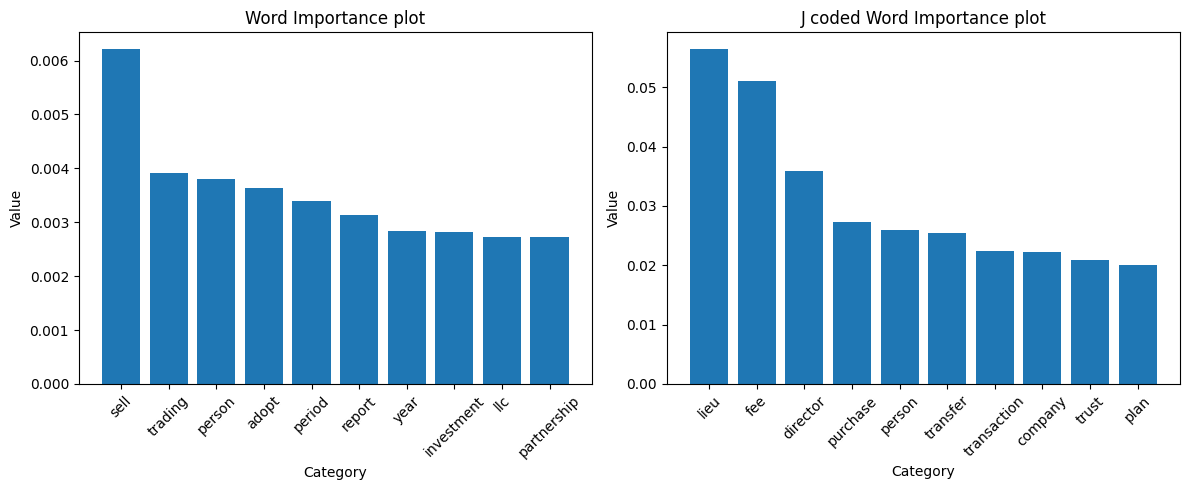

In [29]:
# Top 10 suspicious words Non-J coded and J coded
top_10_data = suspicious_words.head(10)
top_10_data_j = suspicious_words_j.head(10)

plt.figure(figsize=(12, 5))

########################
# Plot Non-J coded word importance
########################
plt.subplot(1, 2, 1)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Word Importance plot')
plt.bar(top_10_data.index, top_10_data.values)
plt.xticks(rotation=45)

########################
# Plot J coded word importance
########################
plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('J coded Word Importance plot')
plt.bar(top_10_data_j.index, top_10_data_j.values)

# Adjust layout and show
plt.tight_layout()
plt.show()


___
## Importance of features
___

### Feature creation:

In [35]:
def count_lemmatized(row, string):
    processed_text = preprocess_text(row)
    processed_string = preprocess_text(string)
    occurance = processed_text.count(processed_string)
    return occurance

In [ ]:
count_lemmatized("The reporting person received a grant of 375 restricted stock units of Adams Resources & Energy, \
                 Inc. (AE) on June 29, 2018.  Each restricted stock unit represents a contingent right to receive one\
                 share of AE common stock upon vesting. The restricted stock units will vest (i.e., the restrictions will lapse)\
                 on May 8, 2019, provided the reporting person remains in continuing active service on the vesting date (subject to accelerated vesting in some circumstances).",
                 "restricted")

reporting person receive grant restricted stock unit adams resource & energy inc ae restrict stock unit represent contingent right receive one share ae common stock upon vest restricted stock unit vest ie restriction lapse provide report person remain continue active service vesting date subject accelerate vesting circumstance


4

In [ ]:
## Items to check
text_list = ["force sale", "gift", "distribution", "charity"] # From research paper
text_from_keywords = ["sell", "trading", "lieu", "fee"] # From TF-IDF 
text_code = ["10b5-1", "16b-3"] # Trading codes from research paper

text_list.extend(text_from_keywords)
df_features = df_footnote_labels.copy()

print("Creating processed footnotes")
df_features["processed"] = df_features["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))

for text in text_list:
    print(f"Creating feature for {text}")
    df_features[text] = df_features["processed"].str.count(preprocess_text(text))

for code in text_code:
    print(f"Creating feature for {code}")
    df_features[code] = df_features["FOOTNOTE_TXT"].str.count(code)
    

text_list = text_list + ["probability", "prediction"]
df_features = df_features[text_list + text_code]
df_features.head()

Creating processed footnotes
Creating feature for force sale
Creating feature for gift
Creating feature for distribution
Creating feature for charity
Creating feature for sell
Creating feature for trading
Creating feature for lieu
Creating feature for fee
Creating feature for 10b5-1
Creating feature for 16b-3


,force sale,gift,distribution,charity,sell,trading,lieu,fee,probability,prediction,10b5-1,16b-3
2,0,0,0,0,0,0,0,0,0.478567,0,0,0
764,0,1,0,0,0,0,0,0,0.893302,1,0,0
766,0,0,0,0,0,0,0,0,0.999999,1,0,0
768,0,0,5,0,0,0,0,0,0.893302,1,0,0
769,0,0,0,0,0,0,0,0,0.599162,1,0,0


In [62]:
df_features.to_csv("word_count.csv")

In [63]:
print(text_list)

['force sale', 'gift', 'distribution', 'charity', 'sell', 'trading', 'lieu', 'fee', 'probability', 'prediction']


In [64]:
for col in df_features.columns:
    if col == "probability" or col == "prediction":
        continue
    print(f'{col}: {sum(df_features[col])}')

force sale: 4
gift: 3809
distribution: 5801
charity: 127
sell: 184495
trading: 44114
lieu: 761
fee: 2485
10b5-1: 56184
16b-3: 3032


In [65]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] >= 1]
    split_2 = df[df[col] < 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}\n")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")

In [66]:
metrics = ["probability", "prediction"]

In [67]:
df_features.columns

Index(['force sale', 'gift', 'distribution', 'charity', 'sell', 'trading',
       'lieu', 'fee', 'probability', 'prediction', '10b5-1', '16b-3'],
      dtype='object')

In [68]:
compare_complement(df_features,"force sale", metrics)

probability: is more negative when force sale is separated
t-statistic = -0.5458812148347648, p-value = 0.6231202604924639
mean force sale = 0.5834655259352337, mean force sale complement = 0.6813507182754799

prediction: is more negative when force sale is separated
t-statistic = -0.594439818898156, p-value = 0.5940644775638365
mean force sale = 0.5, mean force sale complement = 0.6716017503440385

force sale: n = 4, force sale complement: n = 129346



In [69]:
compare_complement(df_features,"gift", metrics)

probability: is more positive when gift is separated
t-statistic = 2.6673567246051935, p-value = 0.0076831195581783295
mean gift = 0.695563021405891, mean gift complement = 0.6810006024786335

prediction: is more negative when gift is separated
t-statistic = -1.3674184482631575, p-value = 0.17158927945153196
mean gift = 0.6600713590658449, mean gift complement = 0.6718778461514093

gift: n = 3083, gift complement: n = 126267



In [70]:
compare_complement(df_features,"distribution", metrics)

probability: is more positive when distribution is separated
t-statistic = 11.705697804320407, p-value = 5.885447734708528e-31
mean distribution = 0.7414040294010723, mean distribution complement = 0.6800470271984884

prediction: is more positive when distribution is separated
t-statistic = 12.271248835131708, p-value = 8.82113912227065e-34
mean distribution = 0.7695113056163384, mean distribution complement = 0.669475862504739

distribution: n = 2742, distribution complement: n = 126608



In [71]:
compare_complement(df_features,"charity", metrics)

probability: is more negative when charity is separated
t-statistic = -2.883215216494379, p-value = 0.004665227492142591
mean charity = 0.5932127472332956, mean charity complement = 0.6814302140057477

prediction: is more negative when charity is separated
t-statistic = -3.8521815742728815, p-value = 0.00018926165163655686
mean charity = 0.49586776859504134, mean charity complement = 0.6717609824420215

charity: n = 121, charity complement: n = 129229



In [72]:
compare_complement(df_features,"sell", metrics)

probability: is more negative when sell is separated
t-statistic = -14.021268167565596, p-value = 1.2584666212289288e-44
mean sell = 0.6675083387410162, mean sell complement = 0.6915400242291829

prediction: is more negative when sell is separated
t-statistic = -12.975943886713491, p-value = 1.781512063123664e-38
mean sell = 0.6517863652934743, mean sell complement = 0.6861860652436569

sell: n = 54860, sell complement: n = 74490



In [73]:
compare_complement(df_features,"trading", metrics)

probability: is more negative when trading is separated
t-statistic = -27.237070607468617, p-value = 1.648572507789797e-162
mean trading = 0.6458893648824717, mean trading complement = 0.6966264887194621

prediction: is more negative when trading is separated
t-statistic = -22.962210847669684, p-value = 2.966193162828205e-116
mean trading = 0.6251540357362908, mean trading complement = 0.6916082214208279

trading: n = 38952, trading complement: n = 90398



In [74]:
compare_complement(df_features,"lieu", metrics)

probability: is more positive when lieu is separated
t-statistic = 0.26303358737788185, p-value = 0.7926063990428849
mean lieu = 0.68416605066987, mean lieu complement = 0.6813333250883843

prediction: is more positive when lieu is separated
t-statistic = 0.7096806639307324, p-value = 0.47815213546369795
mean lieu = 0.6844512195121951, mean lieu complement = 0.6715309183023296

lieu: n = 656, lieu complement: n = 128694



In [75]:
compare_complement(df_features,"fee", metrics)

probability: is more positive when fee is separated
t-statistic = 1.930598167439492, p-value = 0.053719784731896716
mean fee = 0.6954671728766384, mean fee complement = 0.6811851623398049

prediction: is more positive when fee is separated
t-statistic = 3.3161158422808574, p-value = 0.0009344814285477117
mean fee = 0.7105978260869565, mean fee complement = 0.6711474999609003

fee: n = 1472, fee complement: n = 127878



In [76]:
compare_complement(df_features, "10b5-1", metrics)

probability: is more negative when 10b5-1 is separated
t-statistic = -20.539711743399785, p-value = 1.472816044845225e-93
mean 10b5-1 = 0.6594931968865535, mean 10b5-1 complement = 0.6953554612522233

prediction: is more negative when 10b5-1 is separated
t-statistic = -19.000754748464903, p-value = 2.2973769247691525e-80
mean 10b5-1 = 0.6403887261499486, mean 10b5-1 complement = 0.6915992185319565

10b5-1: n = 50524, 10b5-1 complement: n = 78826



In [77]:
compare_complement(df_features, "16b-3", metrics)

probability: is more negative when 16b-3 is separated
t-statistic = -5.270828364642856, p-value = 1.476618510909567e-07
mean 16b-3 = 0.6475210733463718, mean 16b-3 complement = 0.6819793147155021

prediction: is more negative when 16b-3 is separated
t-statistic = -6.263511721966483, p-value = 4.4307905289900696e-10
mean 16b-3 = 0.6094474905103332, mean 16b-3 complement = 0.6727569125603446

16b-3: n = 2371, 16b-3 complement: n = 126979



## Train test split on binary labels

In [ ]:
labels = ["prediction", "probability"]

In [82]:
df_features

,force sale,gift,distribution,charity,sell,trading,lieu,fee,probability,prediction,10b5-1,16b-3
2,0,0,0,0,0,0,0,0,0.478567,0,0,0
764,0,1,0,0,0,0,0,0,0.893302,1,0,0
766,0,0,0,0,0,0,0,0,0.999999,1,0,0
768,0,0,5,0,0,0,0,0,0.893302,1,0,0
769,0,0,0,0,0,0,0,0,0.599162,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
778531,0,0,0,0,0,0,0,0,0.478567,0,0,0
778534,0,0,0,0,0,0,0,0,0.478567,0,0,0
778535,0,0,0,0,0,0,0,0,0.478567,0,0,0
778536,0,0,0,0,0,0,0,0,0.478567,0,0,0


In [85]:
df_log = df_features.copy()
df_log = df_log.dropna(subset=labels)
X, y = df_log.drop(columns=labels), df_log[labels[1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (103480, 10)
train size y: (103480,)
test size x: (25870, 10)
test size y: (25870,)


## Fit log regression on labels

In [108]:
def find_significance(data, columns, label):
    data = data.dropna(subset=[label])
    X = data[columns]
    y = data[label]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
    
    X_with_const = sm.add_constant(train_x)
    model = sm.Logit(train_y, X_with_const).fit()

    print(model.summary())

In [110]:
variables = ["force sale", "gift", "distribution", "charity", "sell", "trading", "lieu", "fee", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588448
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103469
Method:                           MLE   Df Model:                           10
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06831
Time:                        09:39:49   Log-Likelihood:                -60893.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8343      0.009     96.647      0.000       0.817       0.851
force sale       0.2117

In [ ]:
## Remove force sale
variables = ["gift", "distribution", "charity", "sell", "trading", "lieu", "fee", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588448
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103470
Method:                           MLE   Df Model:                            9
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06832
Time:                        00:28:20   Log-Likelihood:                -60893.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8343      0.009     96.650      0.000       0.817       0.851
gift             0.0366

In [ ]:
# Remove Gift
variables = ["distribution", "charity", "sell", "trading", "lieu", "fee", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588455
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103471
Method:                           MLE   Df Model:                            8
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06833
Time:                        00:28:49   Log-Likelihood:                -60893.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8356      0.009     97.701      0.000       0.819       0.852
distribution     0.0762

In [ ]:
# Remove lieu
variables = ["distribution", "charity", "sell", "trading", "fee", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588459
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103472
Method:                           MLE   Df Model:                            7
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06834
Time:                        00:29:18   Log-Likelihood:                -60894.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8351      0.009     97.757      0.000       0.818       0.852
distribution     0.0760

In [ ]:
# Remove Charity
variables = ["distribution", "sell", "trading", "fee", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588480
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103473
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06837
Time:                        00:29:36   Log-Likelihood:                -60896.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8348      0.009     97.753      0.000       0.818       0.852
distribution     0.0760

In [ ]:
# Remove fee
variables = ["distribution", "sell", "trading", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.588504
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               103480
Model:                          Logit   Df Residuals:                   103474
Method:                           MLE   Df Model:                            5
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                -0.06842
Time:                        00:30:08   Log-Likelihood:                -60898.
converged:                       True   LL-Null:                       -56999.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8359      0.009     98.179      0.000       0.819       0.853
distribution     0.0765

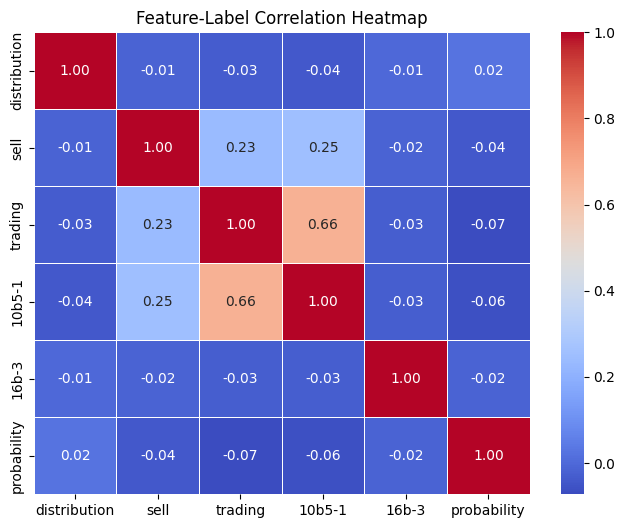

In [ ]:

variables = ["distribution", "sell", "trading", "10b5-1", "16b-3"]
label = "probability"

corr_feature = df_features[variables + [label]]

corr = corr_feature.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

### Trading and 10b5-1 is correlated but we'll leave it in